# AI for Predicting Stock Prices

This Jupyter Notebook demonstrates how to use machine learning models to predict stock prices based on historical data. We will focus on linear models, simple neural networks, and Random Forest, covering time series analysis, regression, and evaluation metrics.

## Phase 1: Set up project environment and data collection

We start by importing necessary libraries and downloading historical stock data using `yfinance`.

In [ ]:
!pip install yfinance

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor # New import
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Define the stock ticker and date range
TICKER = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = '2023-01-01'

# Download historical stock data
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

print(f"Downloaded data for {TICKER} from {START_DATE} to {END_DATE}.")
print(df.head())


/var/folders/nn/gtbx2x9102vdb7gn1nfc4ct00000gp/T/ipykernel_45435/2467408271.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Downloaded data for AAPL from 2010-01-01 to 2023-01-01.
Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.431895  6.446621  6.382907  6.414463  493729600
2010-01-05  6.443016  6.479382  6.409054  6.449628  601904800
2010-01-06  6.340531  6.468562  6.333919  6.443016  552160000
2010-01-07  6.328811  6.371488  6.282828  6.363974  477131200
2010-01-08  6.370887  6.371488  6.283129  6.320396  447610800


## Phase 2: Data Exploration and Preprocessing

### Initial Data Inspection

Let's start by inspecting the downloaded data to understand its structure and content.


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3272 non-null   float64
 1   (High, AAPL)    3272 non-null   float64
 2   (Low, AAPL)     3272 non-null   float64
 3   (Open, AAPL)    3272 non-null   float64
 4   (Volume, AAPL)  3272 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.4 KB
Descriptive Statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   3272.000000  3272.000000  3272.000000  3272.000000  3.272000e+03
mean      48.837106    49.361432    48.273689    48.813946  2.562707e+08
std       47.212410    47.790602    46.591678    47.184467  2.225648e+08
min        5.771907     5.890619     5.717809     5.781525  3.519590e+07
25%       16.413699    16.600551    

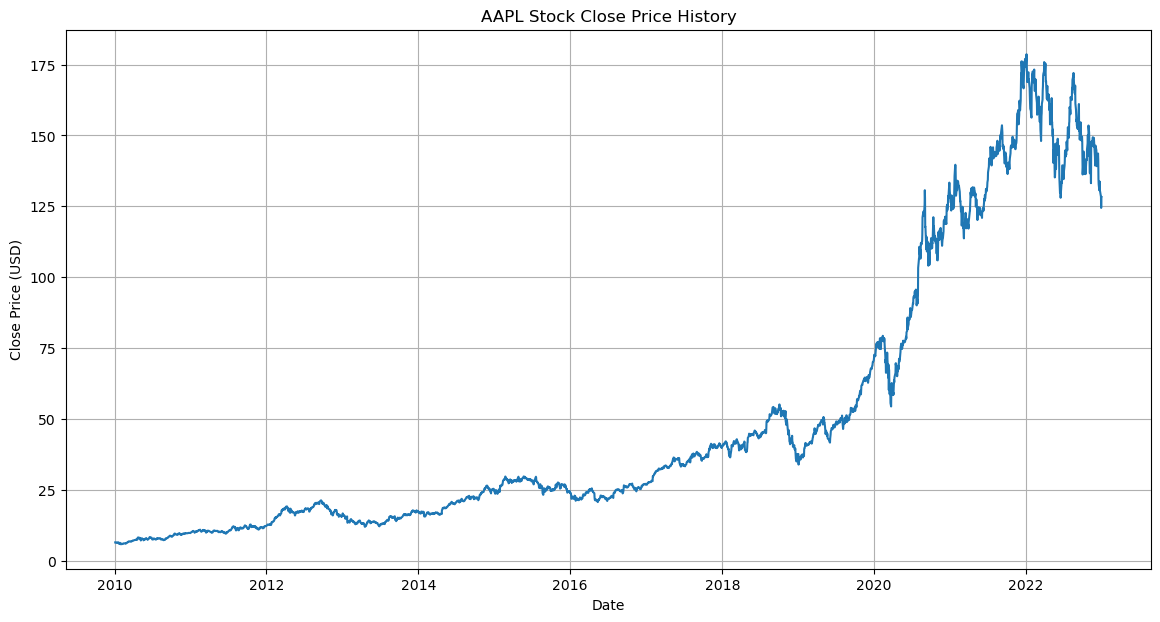

In [2]:
print("Data Info:")
df.info()

print("Descriptive Statistics:")
print(df.describe())

print("Missing Values:")
print(df.isnull().sum())

# Plotting the 'Close' price over time
plt.figure(figsize=(14, 7))
plt.plot(df["Close"])
plt.title(f'{TICKER} Stock Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()


### Data Preprocessing

Before building our model, we need to preprocess the data. This involves handling any missing values and scaling the features to ensure they are on a similar scale, which can improve model performance.


In [3]:
# Handle missing values (if any) - forward fill is common for time series data
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True) # Fill any remaining NaNs at the beginning

# Select features and target variable
# We will use 'Open', 'High', 'Low', 'Volume' to predict 'Close'
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

X = df[features]
y = df[target]

# Scaling features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

print("""Features after scaling (first 5 rows):
""", X_scaled[:5])
print("""Target after scaling (first 5 rows):
""", y_scaled[:5])


Features after scaling (first 5 rows):
 [[0.00364864 0.00320153 0.00391024 0.24841975]
 [0.00385135 0.00339016 0.00406397 0.30702582]
 [0.00381323 0.00332786 0.00362224 0.28007558]
 [0.00335759 0.0027689  0.00332186 0.23942724]
 [0.00310637 0.0027689  0.00332363 0.22343397]]
Target after scaling (first 5 rows):
 [[0.00381774]
 [0.00388207]
 [0.00328924]
 [0.00322145]
 [0.00346484]]


## Phase 3: Time Series Analysis and Feature Engineering

To improve our model's predictive power, we will engineer new features from the existing time series data. These include lagged features (previous day's prices) and moving averages.

### Lagged Features

Lagged features help the model understand the temporal dependency in the data, i.e., how past values influence future values.


In [4]:
# Create lagged features for the 'Close' price
for i in range(1, 6): # Lag by 1 to 5 days
    df[f'Close_Lag_{i}'] = df['Close'].shift(i)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

print("""DataFrame with lagged features (first 5 rows):
""")
print(df.head())


DataFrame with lagged features (first 5 rows):

Price          Close      High       Low      Open     Volume Close_Lag_1  \
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL               
Date                                                                        
2010-01-11  6.314686  6.401542  6.264796  6.395531  462229600    6.370887   
2010-01-12  6.242856  6.304468  6.203786  6.287035  594459600    6.314686   
2010-01-13  6.330912  6.339327  6.134058  6.247362  605892000    6.242856   
2010-01-14  6.294247  6.325203  6.281925  6.314684  432894000    6.330912   
2010-01-15  6.189057  6.359465  6.187254  6.339328  594067600    6.294247   

Price      Close_Lag_2 Close_Lag_3 Close_Lag_4 Close_Lag_5  
Ticker                                                      
Date                                                        
2010-01-11    6.328811    6.340531    6.443016    6.431895  
2010-01-12    6.370887    6.328811    6.340531    6.443016  
2010-01-13    6.314686    6.37

### Moving Averages

Moving averages smooth out price data over a specified period, helping to identify trends and reduce noise. We will create Simple Moving Averages (SMA).


In [5]:
# Create Simple Moving Averages (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Drop rows with NaN values created by moving averages
df.dropna(inplace=True)

print("""DataFrame with moving averages (first 5 rows):
""")
print(df.head())

# Update features list to include new engineered features
features_engineered = [f'Close_Lag_{i}' for i in range(1, 6)] + ['SMA_10', 'SMA_20'] + features

X_engineered = df[features_engineered]
y_engineered = df[target]

# Re-scale engineered features and target
scaler_X_engineered = MinMaxScaler()
X_engineered_scaled = scaler_X_engineered.fit_transform(X_engineered)

scaler_y_engineered = MinMaxScaler()
y_engineered_scaled = scaler_y_engineered.fit_transform(y_engineered.values.reshape(-1, 1))

print("""Engineered Features after scaling (first 5 rows):
""", X_engineered_scaled[:5])
print("""Target after scaling (first 5 rows):
""", y_engineered_scaled[:5])


DataFrame with moving averages (first 5 rows):

Price          Close      High       Low      Open     Volume Close_Lag_1  \
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL               
Date                                                                        
2010-02-08  5.834118  5.947122  5.830512  5.881304  478270800    5.874390   
2010-02-09  5.896330  5.935701  5.853052  5.903242  632886800    5.834118   
2010-02-10  5.864173  5.908654  5.838327  5.887315  370361600    5.896330   
2010-02-11  5.970864  6.003323  5.832315  5.856959  550345600    5.864173   
2010-02-12  6.022260  6.060128  5.875595  5.954036  655468800    5.970864   

Price      Close_Lag_2 Close_Lag_3 Close_Lag_4 Close_Lag_5    SMA_10    SMA_20  
Ticker                                                                          
Date                                                                            
2010-02-08    5.771907    5.987697    5.886412    5.852453  5.940571  6.095169  
2010-02-09 

## Phase 4: Build and Train Machine Learning Models

In this phase, we will select appropriate machine learning models, split our data into training and testing sets, and then train the models to predict stock prices.

### Data Splitting

We will split the data into training and testing sets to evaluate the model's performance on unseen data. For time series data, it's crucial to maintain the temporal order, so we will use a time-based split rather than a random split.


In [6]:
# Convert scaled numpy arrays back to pandas DataFrames for easier handling with time-based split
X_engineered_scaled_df = pd.DataFrame(X_engineered_scaled, columns=features_engineered, index=df.index)
y_engineered_scaled_df = pd.DataFrame(y_engineered_scaled, columns=[target], index=df.index)

# Define the split point (e.g., 80% for training, 20% for testing)
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train, X_test = X_engineered_scaled_df[:split_index], X_engineered_scaled_df[split_index:]
y_train, y_test = y_engineered_scaled_df[:split_index], y_engineered_scaled_df[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (2598, 11)
Testing data shape: (650, 11)


### Linear Regression Model

Linear Regression is a simple yet effective model for regression tasks. It models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data.


In [7]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

print("Linear Regression model trained.")


Linear Regression model trained.


### Random Forest Regressor Model

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the mean prediction of the individual trees.


In [8]:
# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel()) # .ravel() is used to flatten y_train for RandomForestRegressor

print("Random Forest Regressor model trained.")


Random Forest Regressor model trained.


### Simple Neural Network Model

For a simple neural network, we will use `sklearn.neural_network.MLPRegressor`. This is a basic feedforward neural network.


In [11]:
# Initialize and train the MLP Regressor (simple Neural Network)
# We'll use a small hidden layer for simplicity
nn_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train.values.ravel()) # .ravel() is used to flatten y_train for MLPRegressor

print("Simple Neural Network model trained.")


Simple Neural Network model trained.


## Phase 5: Evaluate Models and Create Visualizations

After training our models, it's crucial to evaluate their performance using appropriate metrics and visualize their predictions.

### Model Evaluation

We will use Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) to evaluate the models. These metrics quantify the difference between predicted values and actual values.


In [13]:
# Make predictions
linear_predictions = linear_model.predict(X_test)
nn_predictions = nn_model.predict(X_test)
rf_predictions = rf_model.predict(X_test) # New prediction

# Inverse transform the predictions to original scale
linear_predictions_original = scaler_y_engineered.inverse_transform(linear_predictions.reshape(-1, 1))
nn_predictions_original = scaler_y_engineered.inverse_transform(nn_predictions.reshape(-1, 1))
rf_predictions_original = scaler_y_engineered.inverse_transform(rf_predictions.reshape(-1, 1)) # New inverse transform
y_test_original = scaler_y_engineered.inverse_transform(y_test)

# Evaluate Linear Regression
rmse_linear = np.sqrt(mean_squared_error(y_test_original, linear_predictions_original))
mae_linear = mean_absolute_error(y_test_original, linear_predictions_original)

print(f"Linear Regression Model Performance:")
print(f"RMSE: {rmse_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")

# Evaluate Random Forest Regressor
rmse_rf = np.sqrt(mean_squared_error(y_test_original, rf_predictions_original))
mae_rf = mean_absolute_error(y_test_original, rf_predictions_original)

print(f"Random Forest Regressor Model Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

# Evaluate Simple Neural Network
rmse_nn = np.sqrt(mean_squared_error(y_test_original, nn_predictions_original))
mae_nn = mean_absolute_error(y_test_original, nn_predictions_original)

print(f"Simple Neural Network Model Performance:")
print(f"RMSE: {rmse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")

Linear Regression Model Performance:
RMSE: 1.0369
MAE: 0.7917
Random Forest Regressor Model Performance:
RMSE: 61.7927
MAE: 57.9204
Simple Neural Network Model Performance:
RMSE: 7.9870
MAE: 7.2546


### Visualization of Predictions

Visualizing the predicted prices against the actual prices helps us understand how well the models are performing visually.


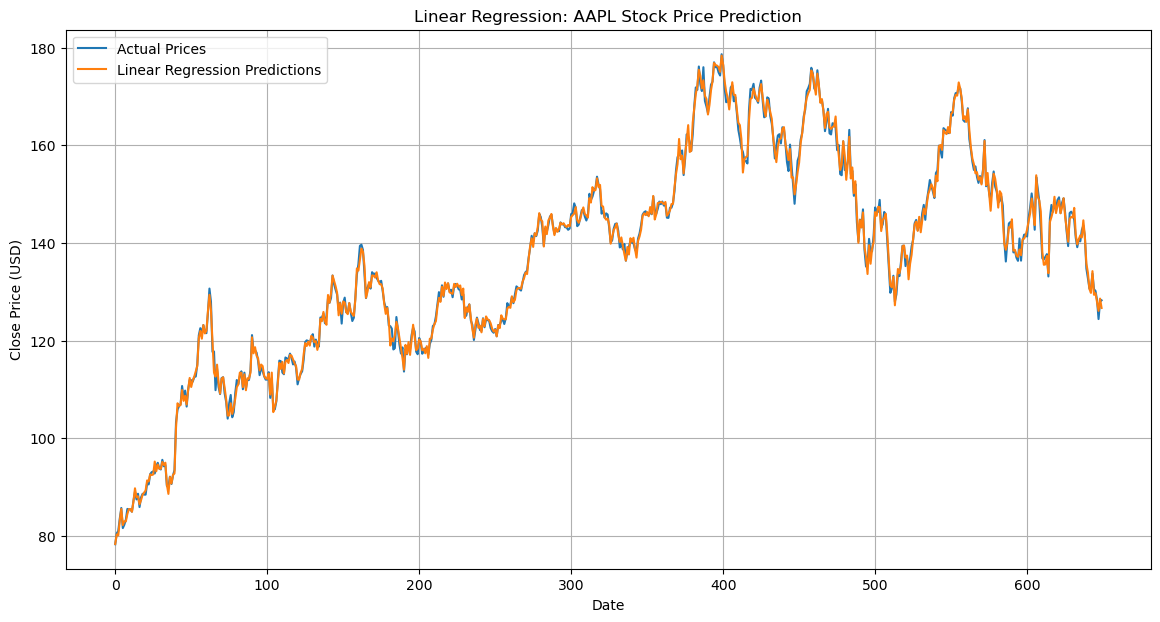

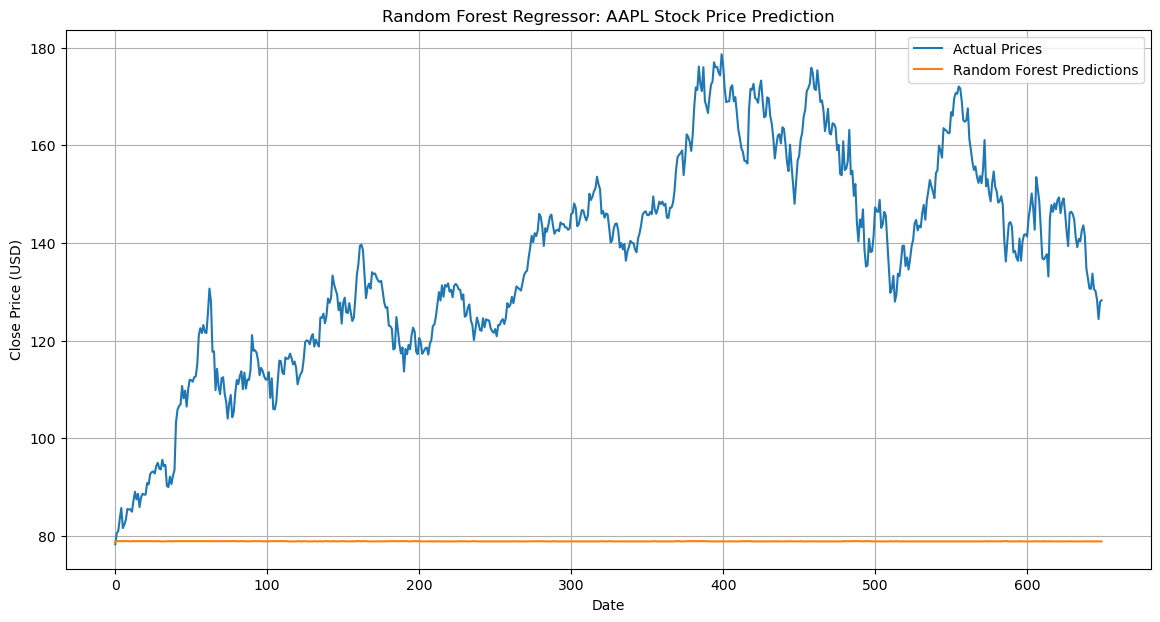

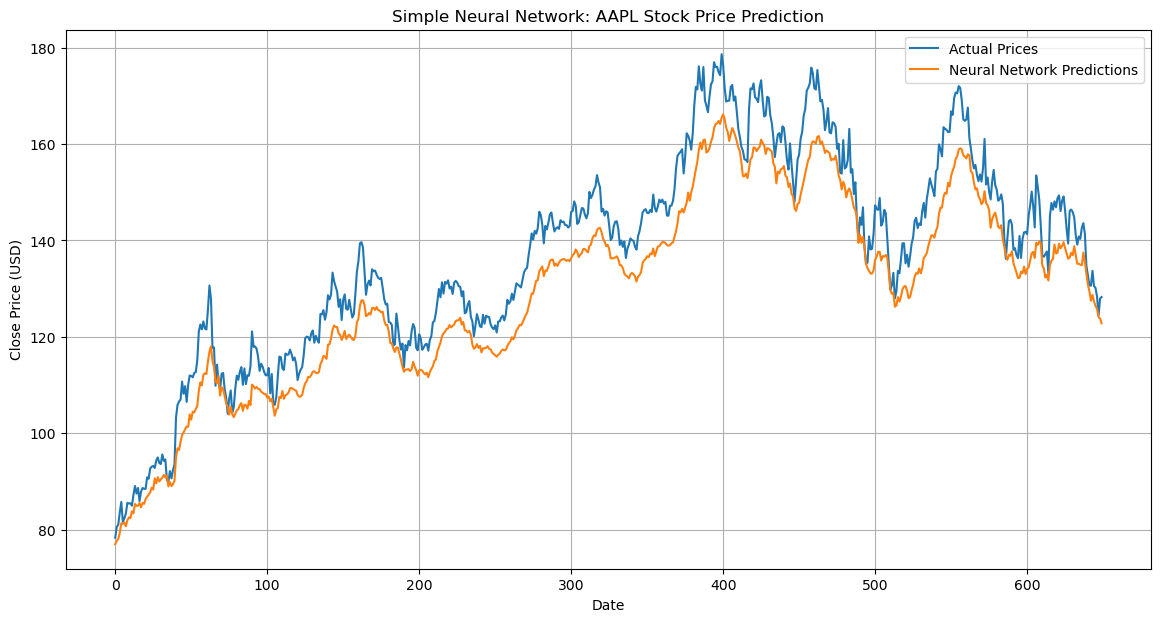

In [15]:
# Plotting actual vs. predicted prices for Linear Regression
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(linear_predictions_original, label='Linear Regression Predictions')
plt.title(f'Linear Regression: {TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs. predicted prices for Random Forest Regressor
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(rf_predictions_original, label='Random Forest Predictions')
plt.title(f'Random Forest Regressor: {TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs. predicted prices for Simple Neural Network
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(nn_predictions_original, label='Neural Network Predictions')
plt.title(f'Simple Neural Network: {TICKER} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()




## Conclusion

From the performance of the Linear Regression, the RMSE is 1.0369 and MAE is 0.7917 which indicates a strong fit for the dataset. And graphically, the model fits the dataset well . So, we can say that the Linear Regression is a good fit for the dataset.  

In the model of Random Forest, the values are moderate and from the graph , it is an underfit model for the dataset and till now the linear regression is a better representer for the dataset. 
For the Random Forerst Model , it has 61.7927 as a value for RMSE and a 57.9204 for MAE. We can also observe from the graph that it seems an underfit model for the dataset that may be caused by the insufficient Trees , incorrect hyperparameters. 

Using the Simple Neural Networks, from the performance values and the graph it seems a better model then the Random Forest one . we notice that with some tuning the hyperparameters the model may fit better on the dataset. 

So , we can say that the Linear Regression is a very strong fit for the dataset. 

